<a href="https://colab.research.google.com/github/tomersk/python-applications/blob/main/05_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.3 Soil moisture modelling using Richards' equation
Numerical solution of Richards' equation is available in *ambhas.richards* library. This library reads input from xls file and writes the output in netcdf format.

This solves the mixed (soil moisture - pressure head) form of Richards' equation by using finte difference. Top boundary condition is atmospheric (rainfall and PET). If rainfall is higher, then water will start ponding. It is assumed that ponding water is immidiately removed and it will become runoff. Bottom boundary condition is gravity drainage (i.e. there is no vertical gradient in soil moisture at bottom boundary condition) and the downward flux is equal to hydraulic conductivity. 

Input *xls* file has following sheets:

**ind**

In this sheet we can change the row number from which Python will read the input. This sheet has following variables in it:

* soil_hyd_par	
* units	
* temporal_info	
* spatial_info	
* initial_condition	
* output_par	

Benefit of changing indices is that you can store multiple variables and just by changing the indices, Python will use that particular row. For example, you can store multiple (entire range, for different soil types) values of soil hydraulic parameters in *soil_hyd_par* sheet. This becomes helpful for sensitivity analysis, you can store different input in the same file, and you can easily run iterations over different inputs.

**soil_hyd_par**

This sheet has following variables:

* theta_r: residual soil moisture
*	theta_s: saturated soil moisture
*	alpha: inverse of capillary fringe thickness
*	n: Shape parameters. It is very sensitive parameter for soil moisture.
*	ks: Saturated hydraulic conductivity
*	l: Usually there is no need to change. Default value of it is 0.5.
*	evap_0: If soil moisture is below this, AET becomes 0. Usually this correspons to wilting point.
*	evap_1: If soil moisture is higher than this, AET becomes equal to PET. Usually this corresponds to field capacity.

** forcing **

This sheet has following variables:

* year: Not used in the computation. It is just written in the output netcdf file.	
* doy: Not used in the computation. It is just written in the output netcdf file.
* rain: Rainall in length unit. Unit can be either in *m* or *mm*. Units are defined in *units* sheet.	
* pet: Potential Evapotranspiration in length unit. Units can be either in *m* or *mm*.


** initial_condition **

This sheet takes the initial condition in soil moisture. Currently, only homogeneous soil moisture can be defined.

** units **

In this sheet, we need to define units for *rain* and *pet*. Units can be in either *m* or *mm*. However, units for rain and pet can be different.

** temporal_info **

In this sheet, we need to define the followings:

* dt_flux: Number of seconds in each time step. For a daily data, it is 86,400.
* final_time: Final time in number of seconds e.g. for one year of simulation, it will be 365*86400. This should be less than the length of the forcing data.

** spatial_info **

* no_layer: Total number of soil layers.
*	dz: Thickness of one soil layer. If you take 100 layers and thickness of one layer (dz) is 0.025 m, depth of total soil profile is 2.5 m. You can define the depth of total soil profile by controlling these two parameters. 

Do not take very low value of the thickness of soil profile, as the assumption of gravity drainage may not hold true. Do not take very high value of soil profile either, as if bottom soil touches groundwater table, again bottom boundary conditions may not hold true. Usually for a deep ground water table (e.g. more than 5 m), soil profile depth can be taken around 1.5 - 2.5 m.


** output_par **

This sheet defines the location of file where output will be saved. It has to be a netcdf file (extention should be .nc).

*Note that you should not change the values in *ind* column for an sheet.*

Let us import required libraries.

In [28]:
from ambhas.richards import RICHARDS_1D
from google.colab import drive
import matplotlib.pyplot as plt
from scipy.io import netcdf as nc

#drive.mount('/content/gdrive')

We will be using example file provided which contains all the required inputs. It is advised to modify this file for your need rather than creating input file from scratch. 

In [29]:
file_name = "/content/gdrive/My Drive/Colab Notebooks/PythonApplications/data/maddur.xls"    
ofile_name = '/content/gdrive/My Drive/Colab Notebooks/PythonApplications/data/maddur_out.nc'

maddur = RICHARDS_1D(file_name, ofile_name=ofile_name)
output_file = nc.NetCDFFile(maddur.ofile_name, 'r')

Input data reading completed successfully
25 % completed
50 % completed
75 % completed
100 % completed


We can print all the variables.

In [30]:
for var in output_file.variables:
  print(var)

year
doy
rain
aet
recharge
sm
depth


Let us take *depth* and *sm* variable and make a plot of SM at initial condition and after one year.

/usr/local/lib/python3.7/dist-packages/scipy/io/netcdf.py:312: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


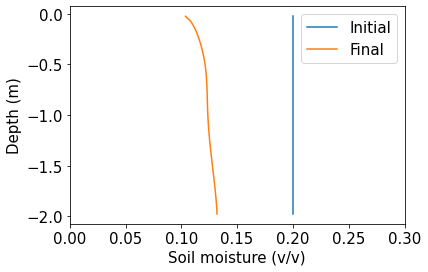

In [31]:
params = {'axes.labelsize': 15, 
          'font.size': 15,
          'legend.fontsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'text.usetex': False}
plt.rcParams.update(params)

output_file = nc.NetCDFFile(maddur.ofile_name, 'r')
theta = output_file.variables['sm'][:]
doy = output_file.variables['doy'][:]
rain = output_file.variables['rain'][:]
depth = output_file.variables['depth'][:]
output_file.close()

plt.plot(theta[:,0], -depth, label="Initial")
plt.plot(theta[:,-1], -depth, label="Final")
plt.ylabel("Depth (m)")
plt.xlabel("Soil moisture (v/v)")
plt.legend(loc="best")
plt.xlim((0,0.3))
plt.show()

We can see from the figure that initial condition is uniform across the depth. However, after going through a cycle hydrological process, there is a variation in the soil moisture. Let us look at how soil moisture at different depth is evolving over the entire year.

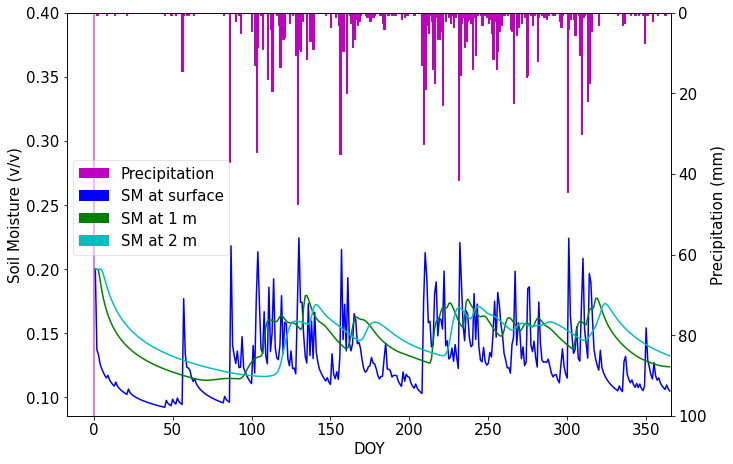

In [35]:
# main plot
fig = plt.figure(figsize=(12, 8))
ax = plt.axes([0.15, 0.15, 0.7, 0.7])
ax.plot(doy[:-1],theta[0,:-1],'b') 
ax.plot(doy[:-1],theta[20,:-1],'g')
ax.plot(doy[:-1],theta[39,:-1],'c')
ax.set_ylabel('Soil Moisture (v/v)')
ax.set_ylim(ymax=0.4)
ax.set_xlim(xmax=366)
ax.set_xlabel('DOY')
fig.canvas.draw()
	
# precipitation plot
ax2 = plt.twinx()
ax2.bar(doy,rain*86400*1000, label='Precipitation', color='m', edgecolor='m')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(ymax=100)
ax2.set_xlim(xmax=366)
ax2.invert_yaxis()

p1 = plt.Rectangle((0, 0), 1, 1, fc="m")
p2 = plt.Rectangle((0, 0), 1, 1, fc="b")
p3 = plt.Rectangle((0, 0), 1, 1, fc="g")
p4 = plt.Rectangle((0, 0), 1, 1, fc="c")
leg = plt.legend([p1,p2,p3,p4], ["Precipitation","SM at surface", "SM at 1 m", "SM at 2 m"], loc=(0.01,0.4))
frame = leg.get_frame()
frame.set_alpha(0.5)

plt.show()

We can see that SM at all depths is decreasing whenever there is a dry period (no rainfall for longer duration). Whenever there is any rainfall event, surface soil moisture reacts quickly to it, while it takes a while for the impact to be seen at higher depths.